In [1]:
import json
import uuid
import shapely
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from geojson import Point, Feature, FeatureCollection, dump

dir = "/Users/sebastian/Documents/SkiNavApp/"

In [2]:
filename = "runs.geojson"
file = open(filename)
gdf_runs = gpd.read_file(file)

In [23]:
def get_name(data):
    json_file = json.loads(data)
    if len(json_file) > 0:
        name = json_file[0].get("properties").get("name")
    else:
        name = pd.NA
    return name

In [5]:
# filter Les Tois Vallées
gdf_runs["resort_name"] = gdf_runs.skiAreas.apply(lambda x: get_name(x))
gdf_runs = gdf_runs[gdf_runs.resort_name=="Les Trois Vallées"]
gdf_runs = gdf_runs[gdf_runs.elevationProfile.notnull()]

#gdf_runs.to_pickle(dir+"runs_les_trois_vallee.pkl")

In [25]:
filename = "lifts.geojson"
file = open(filename)
gdf_lifts = gpd.read_file(file)

In [ ]:
# filter Les Tois Vallées
gdf_lifts["resort_name"] = gdf_lifts.skiAreas.apply(lambda x: get_name(x))
gdf_lifts = gdf_lifts[gdf_lifts.resort_name=="Les Trois Vallées"]

#gdf_lifts.to_pickle(dir+"lifts_les_trois_vallee.pkl")

In [527]:
gdf_runs = pd.read_pickle(dir+"runs_les_trois_vallee.pkl")
gdf_lifts = pd.read_pickle(dir+"lifts_les_trois_vallee.pkl")

In [528]:
# change to crs france UoM metric
features = ["id", "name", "resort_name", "connection_type", "difficulty",
            "duration", "distance", "geometry", "start", "end"]

gdf_runs = gdf_runs.to_crs("27561")
gdf_runs["uses"] = gdf_runs.uses.apply(lambda x: x[0])
gdf_runs["distance"] = gdf_runs.geometry.length
gdf_runs["start"] = gdf_runs.geometry.apply(lambda x: Point(x.coords[0]))
gdf_runs["end"] = gdf_runs.geometry.apply(lambda x: Point(x.coords[-1]))
gdf_runs["connection_type"] = "run"
gdf_runs["duration"] = gdf_runs["distance"] / 7 # 25km/h or 7m/s
gdf_runs = gdf_runs[gdf_runs.uses=="downhill"]
gdf_runs = gdf_runs[features]

In [529]:
# change to crs france UoM metric
gdf_lifts = gdf_lifts.to_crs("27561")
gdf_lifts["distance"] = gdf_lifts.geometry.length
gdf_lifts["start"] = gdf_lifts.geometry.apply(lambda x: Point(x.coords[0]))
gdf_lifts["end"] = gdf_lifts.geometry.apply(lambda x: Point(x.coords[-1]))
gdf_lifts["geometry"] = gdf_lifts.geometry.apply(lambda x: LineString([x.coords[0], x.coords[-1]]))
gdf_lifts["connection_type"] = "lift"
gdf_lifts = gdf_lifts.rename(columns={"liftType": "lift_type"})
gdf_lifts.head()
gdf_lifts["difficulty"] = "lift"
mean_speed = gdf_lifts[gdf_lifts["duration"].notnull()]["distance"].sum() / gdf_lifts[gdf_lifts["duration"].notnull()].duration.sum()
gdf_lifts["duration"] = np.where(gdf_lifts["duration"].isna(), (gdf_lifts["distance"] / mean_speed), gdf_lifts["duration"])
gdf_lifts = gdf_lifts[features]

In [530]:
data = pd.concat([gdf_lifts, gdf_runs])
#data

In [531]:
test_data = data.copy()
test_data = test_data[test_data["name"].isin(["Béranger", "Lac Blanc", "Tête Ronde", "Croissant",
                                    "Trolles", "Adrien Théaux", "Ardoises", "Boulevard Lauzes",
                                    "Dalles", "Stade", "Corniche", "Roc", "Christine",
                                    "Cascades", "Funitel Péclet", "Pionniers", "Plein Sud", "Vires",
                                    "Bleuets", "2 Combes", "Flocon", "Combe de Thorens"])]

#test_data = test_data[test_data["name"].isin(["3 Vallées", "Boulevard Goitschel", "Goitschel", "Chardons", "Pluviomètre"])]
test_data = test_data[~((test_data["name"].isin(["Stade"])) & (test_data.connection_type=="lift")) & (test_data.geometry.apply(lambda x: x.coords[0][1]) < -256000) & (test_data.geometry.apply(lambda x: x.coords[0][1]) > -260000) & (test_data.geometry.apply(lambda x: x.coords[0][0]) > 933000)]
test_data = test_data[~test_data.id.isin(["4c8d28e91232c0842a7ee27b6b688f83e36871c1", "8ca54533ba58833bb34bf182c41401bcc6ff564e"])] # remove duplicates

<Axes: >

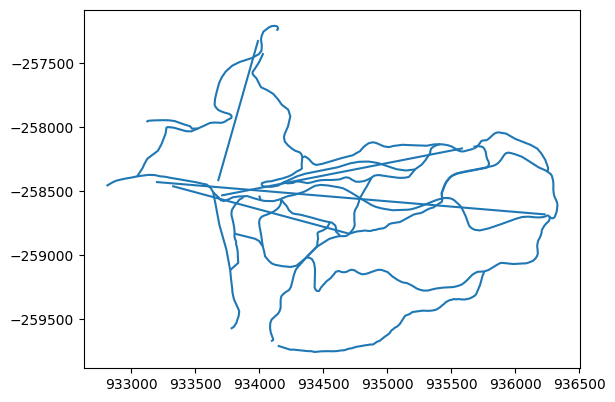

In [532]:
test_data.geometry.plot()

In [533]:
start_points = test_data[["id", "name", "start", "difficulty", "duration", "connection_type"]].rename(columns={"start": "geometry"}).set_geometry("geometry")
start_points["point_type"] = "start"

end_points = test_data[["id", "name", "end", "difficulty", "duration", "connection_type"]].rename(columns={"end": "geometry"}).set_geometry("geometry")
end_points["point_type"] = "end"

start_end_points = pd.concat([start_points, end_points], axis=0)
#start_end_points

In [534]:
points = test_data.geometry.apply(lambda x: x.coords).rename("point").explode().reset_index().rename(columns={"index": "Index"})
test_data = test_data.reset_index().rename(columns={"index": "Index"})
points = points.merge(test_data[["id", "name", "Index", "difficulty", "duration", "connection_type"]], how="left", on="Index")
points = gpd.GeoDataFrame(points, geometry=[Point(x) for x in points.point])

In [ ]:
points.crs = "epsg:27561"
points_wgs = points.to_crs(4326)
points_wgs["point"] = points_wgs.geometry.apply(lambda x: x.coords).rename("point").explode()
points_wgs = points_wgs.iloc[2:]
points_wgs

In [ ]:
geo_json = {"tpye": "FeatureCollection",
            "features": [
                {"name": "Béranger",
                "geometry": {
                    "coordinates" : [x[:2] for x in points_wgs[points_wgs["name"]=="Béranger"].point.values]
                }},
                {"name": "Lac Blanc",
                "geometry": {
                    "coordinates" : [x[:2] for x in points_wgs[points_wgs["name"]=="Lac Blanc"].point.values]
                }},

            ]}

geo_json

In [235]:
with open(dir+'test_file.geojson', 'w') as f:
   dump(geo_json, f)

<Axes: >

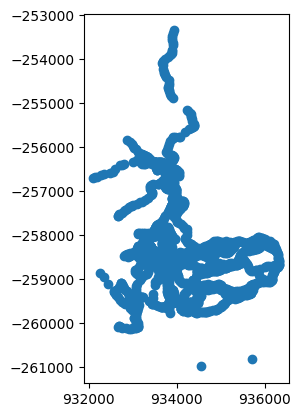

In [138]:
gpd.GeoDataFrame(points, geometry=[Point(x) for x in points.point]).plot()

In [387]:
def get_center(nodes):
    x, y, z, n = [0, 0, 0, 0]
    for x_, y_, z_ in [n.coords[0] for n in nodes]:
        x += x_
        y += y_
        z += z_
        n += 1
    return ((x/n), (y/n), (z/n))


start_ids = []
end_ids = []
nodes_conn = []
buffer_zone = 25

for id, point_type, point_start_end, difficulty_se, duration_se, connection_type_se, name_se in list(zip(start_end_points.id, start_end_points.point_type, start_end_points.geometry, start_end_points.difficulty, start_end_points.duration, start_end_points.connection_type, start_end_points["name"])):
    conns = []
    coords = []
    features = []
    if point_type == "start" and id not in start_ids:
        start_ids.append(id)
        conns.append(id)
        coords.append(point_start_end)
        features.append({"id_connection": id,
                         "name": name_se,
                         "difficulty": difficulty_se,
                         "duration": duration_se,
                         "connection_type": connection_type_se})
        for id_conn, point, difficulty_p, duration_p, connection_type_p, name_p in list(zip(points.id, points.geometry, points.difficulty, points.duration, points.connection_type, points["name"])):
            if (id != id_conn and point.distance(point_start_end) < buffer_zone and id_conn not in conns):
                conns.append(id_conn)
                coords.append(point)
                features.append({"id_connection": id_conn,
                                 "name": name_p,
                                 "difficulty": difficulty_p,
                                 "duration": duration_p,
                                 "connection_type": connection_type_p})
                #start_ids.append(id_conn)


        id_node = str(uuid.uuid4())
        nodes_conn.append({"id_node": id_node,
                            "features": features,
                            "coords": get_center(coords)
        })   


    elif point_type == "end" and id not in end_ids:
        end_ids.append(id)
        conns.append(id)
        coords.append(point_start_end)
        features.append({"id_connection": id,
                         "name": name_se,
                         "difficulty": difficulty_se,
                         "duration": duration_se,
                         "connection_type": connection_type_se})
        for id_conn, point, difficulty_p, duration_p, connection_type_p, name_p in list(zip(points.id, points.geometry, points.difficulty, points.duration, points.connection_type, points["name"])):
            if (id != id_conn and point.distance(point_start_end) < buffer_zone and id_conn not in conns):
                conns.append(id_conn)
                coords.append(point)
                features.append({"id_connection": id_conn,
                                 "name": name_p,
                                 "difficulty": difficulty_p,
                                 "duration": duration_p,
                                 "connection_type": connection_type_p})
                #end_ids.append(id_conn)

        id_node = str(uuid.uuid4())
        nodes_conn.append({"id_node": id_node, # "id_connection": conns,
                            "features": features,
                            "coords": get_center(coords)
        })

    
  
len(nodes_conn)       

228

<Axes: >

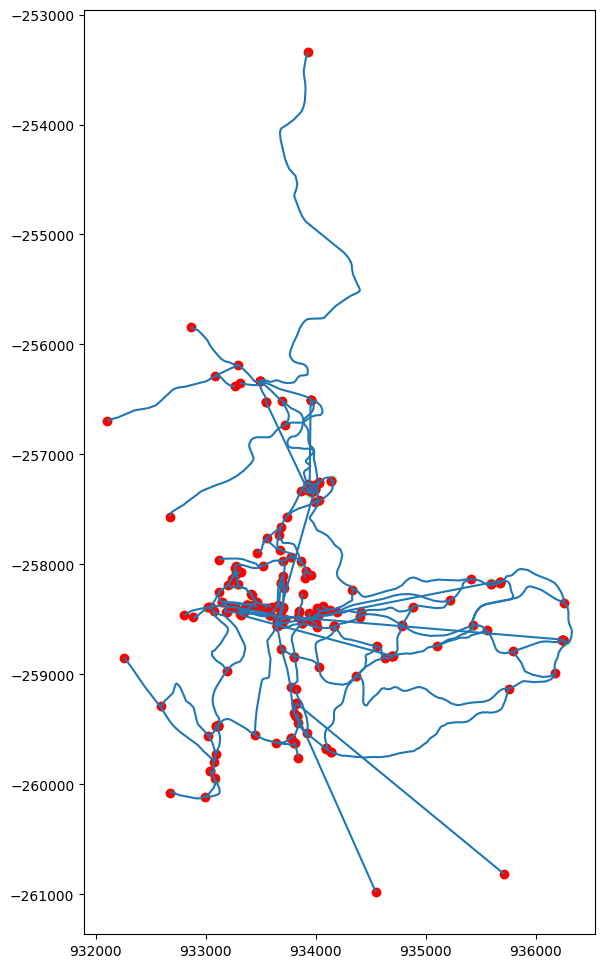

In [388]:
fig, ax = plt.subplots(figsize=(10,12))
test_data.geometry.plot(ax=ax)
start_end_points.geometry.plot(ax=ax, color="lightgreen")
gpd.GeoDataFrame(nodes_conn, geometry=[Point(x.get("coords")) for x in nodes_conn]).plot(ax=ax, color="red")

In [389]:
def get_center(nodes):
    x, y, z, n = [0, 0, 0, 0]
    for x_, y_, z_ in [n for n in nodes]:
        x += x_
        y += y_
        z += z_
        n += 1
    return ((x/n), (y/n), (z/n))

def unique_connection(data):
    connections = []
    output = []
    for i in data:
        if i.get("id_connection") not in connections:
            connections.append(i.get("id_connection"))
            output.append(i)
    return output

nodes_no_duplicates = []
discared_nodes = []
buffer_zone = 50

for node in nodes_conn:
    if node.get("id_node") not in discared_nodes:
        duplicate = False
        duplactes_connections = []
        duplactes_coords = []
        for n in nodes_conn:
            if node.get("id_node") != n.get("id_node") and shapely.points(node.get("coords")).distance(shapely.points(n.get("coords"))) < buffer_zone:
                duplactes_connections.append(n.get("features")) 
                duplactes_coords.append(n.get("coords"))
                discared_nodes.append(n.get("id_node"))
                duplicate = True

        if duplicate == True:
            nodes_no_duplicates.append({"id_node": node.get("id_node"),
                                        "features": unique_connection(node.get("features") + sum(duplactes_connections, [])),
                                        "coords": get_center([node.get("coords")] + duplactes_coords)})

        elif duplicate == False:
            nodes_no_duplicates.append({"id_node": node.get("id_node"),
                                        "features": node.get("features"),
                                        "coords": node.get("coords")})

len(nodes_no_duplicates)

123

<Axes: >

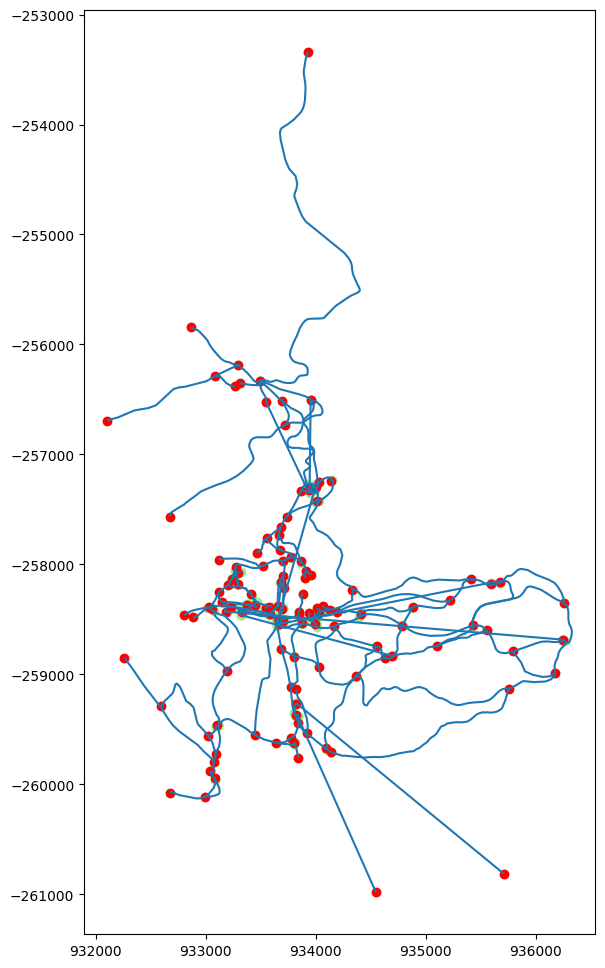

In [390]:
#[Point(x.get("coords")) for x in nodes_conn]
fig, ax = plt.subplots(figsize=(10,12))
test_data.geometry.plot(ax=ax)
start_end_points.geometry.plot(ax=ax, color="lightgreen")
gpd.GeoDataFrame(nodes_no_duplicates, geometry=[Point(x.get("coords")) for x in nodes_no_duplicates]).plot(ax=ax, color="red")


In [391]:
smooth = 2
nodes = []

for node in nodes_no_duplicates:
    features = []
    id_connected_nodes = []
    for feature in node.get("features"):
        conns_candidate = []
        distances = {}
        for n in nodes_no_duplicates:
            if node.get("id_node") != n.get("id_node") and feature.get("id_connection") in [x.get("id_connection") for x in n.get("features")] and (node.get("coords")[2] + smooth) >= n.get("coords")[2] and feature.get("connection_type") == "run":
                conns_candidate.append(n)

            elif node.get("id_node") != n.get("id_node") and feature.get("id_connection") in [x.get("id_connection") for x in n.get("features")] and (node.get("coords")[2] + smooth) <= n.get("coords")[2] and feature.get("connection_type") == "lift":
                conns_candidate.append(n)

        for candiate in conns_candidate:
            distances[candiate.get("id_node")] = shapely.points(node.get("coords")).distance(shapely.points(candiate.get("coords")))

        if len(conns_candidate) > 0:
            closest_node = min(distances, key=distances.get)
            if closest_node not in id_connected_nodes:
                id_connected_nodes.append([x.get("id_node") for x in conns_candidate if x.get("id_node") == closest_node][0])
                features.append(feature)
                
    nodes.append({"id_node": node.get("id_node"),
                  "features": features,
                  "id_connected_nodes": id_connected_nodes,
                  "coords": node.get("coords")})
                

In [392]:
nodes

[{'id_node': '06570f28-391c-4440-b62d-9fea23ba4216',
  'features': [{'id_connection': '11effb194edfdc7596d7fbcc4d28fe2fa13dee65',
    'name': 'Cascades',
    'difficulty': 'lift',
    'duration': 285.0,
    'connection_type': 'lift'},
   {'id_connection': 'befbd0de589264db6d2cb27373a556246724c286',
    'name': 'Campagnols',
    'difficulty': 'lift',
    'duration': 190.0,
    'connection_type': 'lift'},
   {'id_connection': 'cf0cd1dbb3ab10e500d30c5c51fd628db7744d28',
    'name': 'Combe de Thorens',
    'difficulty': 'novice',
    'duration': 285.6291194771849,
    'connection_type': 'run'}],
  'id_connected_nodes': ['847a48e6-ab13-4459-91bf-72f2ce5ba1fc',
   'dbaa3ebc-c77a-472f-9b5a-e5c05abea177',
   'a0bd658a-d93f-4901-b347-37e2ac5b2156'],
  'coords': (933334.166726292, -258429.87108078567, 2250.809492063492)},
 {'id_node': 'd4943d79-0f93-41c8-a590-2f639c0c24f7',
  'features': [{'id_connection': 'c167ad3a1dc0944dabe1e33a9a569d437f03bbd3',
    'name': 'Portette',
    'difficulty': 'lif

In [437]:
points[points.id == run_id].geometry

1342    POINT Z (933124.225 -258248.129 2243.500)
1343    POINT Z (933115.900 -258282.544 2236.750)
1344    POINT Z (933116.959 -258296.869 2234.750)
1345    POINT Z (933123.929 -258312.680 2234.440)
1346    POINT Z (933136.112 -258329.726 2235.120)
1347    POINT Z (933152.939 -258343.787 2235.680)
1348    POINT Z (933189.201 -258376.250 2238.440)
1349    POINT Z (933200.082 -258381.763 2239.360)
1350    POINT Z (933202.259 -258384.486 2239.360)
1351    POINT Z (933201.974 -258387.683 2239.360)
1352    POINT Z (933200.488 -258390.790 2239.360)
Name: geometry, dtype: geometry

In [442]:
check_shape(run_points, start_point, end_point)

['U', 'U', 'U', 'U', 'U', 'U']

In [451]:
test_data[(test_data.start.apply(lambda x: x.coords[0][2]) < test_data.end.apply(lambda x: x.coords[0][2])) & (test_data.connection_type!="lift")]

,Index,id,name,resort_name,connection_type,difficulty,duration,distance,geometry,start,end
40,47847,87c433c36090d045443b7b951cffd556462c4e4b,None,Les Trois Vallées,run,easy,7.090978,49.636847,"LINESTRING Z (933991.475 -257319.912 2540.520,...",POINT Z (933991.475 -257319.912 2540.520),POINT Z (933974.000 -257289.909 2541.640)
46,55275,32b2cdf175ee03453a7fba54ba25ac361b98c04b,None,Les Trois Vallées,run,easy,1.586005,11.102035,"LINESTRING Z (936238.232 -258682.816 2919.050,...",POINT Z (936238.232 -258682.816 2919.050),POINT Z (936247.979 -258688.132 2921.260)
69,58653,1d6bc590520355bd206518161d5634365d2086a5,None,Les Trois Vallées,run,novice,6.484735,45.393145,"LINESTRING Z (933089.704 -259464.644 2446.820,...",POINT Z (933089.704 -259464.644 2446.820),POINT Z (933115.693 -259458.650 2450.430)
70,58661,77f7d3631a24e6f47862cff157703925b04495d0,None,Les Trois Vallées,run,novice,10.499161,73.494125,"LINESTRING Z (933336.931 -258401.808 2250.040,...",POINT Z (933336.931 -258401.808 2250.040),POINT Z (933319.466 -258460.597 2252.490)
85,81339,08b0c4421bb78ab417b27a179e7bcccf2fa565aa,None,Les Trois Vallées,run,novice,5.518438,38.629065,"LINESTRING Z (933814.654 -259374.213 2351.270,...",POINT Z (933814.654 -259374.213 2351.270),POINT Z (933835.753 -259378.871 2352.270)
92,93279,c1d6b9eae987a999716148edd967e21951bc93f6,None,Les Trois Vallées,run,intermediate,14.091935,98.643547,"LINESTRING Z (935591.840 -258165.657 2752.870,...",POINT Z (935591.840 -258165.657 2752.870),POINT Z (935672.854 -258169.118 2758.240)
94,93281,cf1e0863d54b7d65304393a326d072803e13302b,None,Les Trois Vallées,run,novice,8.910438,62.373067,"LINESTRING Z (933649.061 -258559.471 2284.380,...",POINT Z (933649.061 -258559.471 2284.380),POINT Z (933702.069 -258534.899 2289.140)
100,100702,007d28074efd19753d3088959fba87b5c68e13ca,None,Les Trois Vallées,run,easy,2.443311,17.103179,"LINESTRING Z (933650.926 -258374.234 2278.550,...",POINT Z (933650.926 -258374.234 2278.550),POINT Z (933661.799 -258387.436 2279.240)
110,124209,7e756fede58f25ffd9f3312a2b231a67dd1bfdec,None,Les Trois Vallées,run,None,2.331599,16.321195,"LINESTRING Z (933823.417 -259369.099 2351.270,...",POINT Z (933823.417 -259369.099 2351.270),POINT Z (933836.453 -259373.966 2352.270)


In [472]:
run_points.reverse()

run_points

[<POINT Z (933200.488 -258390.79 2239.36)>,
 <POINT Z (933201.974 -258387.683 2239.36)>,
 <POINT Z (933202.259 -258384.486 2239.36)>,
 <POINT Z (933200.082 -258381.763 2239.36)>,
 <POINT Z (933189.201 -258376.25 2238.44)>,
 <POINT Z (933152.939 -258343.787 2235.68)>,
 <POINT Z (933136.112 -258329.726 2235.12)>,
 <POINT Z (933123.929 -258312.68 2234.44)>,
 <POINT Z (933116.959 -258296.869 2234.75)>,
 <POINT Z (933115.9 -258282.544 2236.75)>,
 <POINT Z (933124.225 -258248.129 2243.5)>]

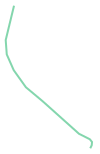

In [482]:
LineString(run_points)

In [494]:
run_points

[<POINT Z (933124.225 -258248.129 2243.5)>,
 <POINT Z (933115.9 -258282.544 2236.75)>,
 <POINT Z (933116.959 -258296.869 2234.75)>,
 <POINT Z (933123.929 -258312.68 2234.44)>,
 <POINT Z (933136.112 -258329.726 2235.12)>,
 <POINT Z (933152.939 -258343.787 2235.68)>,
 <POINT Z (933189.201 -258376.25 2238.44)>,
 <POINT Z (933200.082 -258381.763 2239.36)>,
 <POINT Z (933202.259 -258384.486 2239.36)>,
 <POINT Z (933201.974 -258387.683 2239.36)>,
 <POINT Z (933200.488 -258390.79 2239.36)>]

In [495]:
start_point

(933124.224787, -258248.129494, 2243.5)

In [496]:
end_point

(933200.487623, -258390.790477, 2239.36)

In [499]:
check_shape(run_points, start_point, end_point)

([<POINT Z (933124.225 -258248.129 2243.5)>,
  <POINT Z (933115.9 -258282.544 2236.75)>,
  <POINT Z (933116.959 -258296.869 2234.75)>,
  <POINT Z (933123.929 -258312.68 2234.44)>,
  <POINT Z (933136.112 -258329.726 2233.44)>,
  <POINT Z (933152.939 -258343.787 2232.44)>,
  <POINT Z (933189.201 -258376.25 2231.44)>,
  <POINT Z (933200.082 -258381.763 2230.44)>,
  <POINT Z (933202.259 -258384.486 2229.44)>,
  <POINT Z (933201.974 -258387.683 2228.44)>,
  <POINT Z (933200.488 -258390.79 2227.44)>],
 (933124.224787, -258248.129494, 2243.5),
 <POINT Z (933200.488 -258390.79 2227.44)>,
 False)

In [505]:
node_coords = {}
for smpl in subsample:
    node_coords[smpl.get("id_node")] = shapely.points(smpl.get("coords"))

node_coords

{'a0bd658a-d93f-4901-b347-37e2ac5b2156': <POINT Z (933232.695 -258386.275 2242.046)>,
 '542ee469-28aa-4b02-b8cf-86200a4f0d80': <POINT Z (933124.225 -258248.129 2243.5)>}

In [517]:
node_coords

{'a0bd658a-d93f-4901-b347-37e2ac5b2156': <POINT Z (933232.695 -258386.275 2242.046)>,
 '542ee469-28aa-4b02-b8cf-86200a4f0d80': <POINT Z (933124.225 -258248.129 2243.5)>}

In [519]:
start_point

(933124.224787, -258248.129494, 2243.5)

In [520]:
end_point

(933200.487623, -258390.790477, 2239.36)

In [522]:
run_points

[<POINT Z (933124.225 -258248.129 2243.5)>,
 <POINT Z (933115.9 -258282.544 2236.75)>,
 <POINT Z (933116.959 -258296.869 2234.75)>,
 <POINT Z (933123.929 -258312.68 2234.44)>,
 <POINT Z (933136.112 -258329.726 2235.12)>,
 <POINT Z (933152.939 -258343.787 2235.68)>,
 <POINT Z (933189.201 -258376.25 2238.44)>,
 <POINT Z (933200.082 -258381.763 2239.36)>,
 <POINT Z (933202.259 -258384.486 2239.36)>,
 <POINT Z (933201.974 -258387.683 2239.36)>,
 <POINT Z (933200.488 -258390.79 2239.36)>]

In [ ]:
subsample # 933232.6950008888, -258386.27479766667, 2242.0455555555554    933124.224787, -258248.129494, 2243.5

In [518]:
for id_node in list(node_coords.keys()):
    distance = []
    for point in run_points:
        distance.append(node_coords.get(id_node).distance(point))
    min_index = distance.index(min(distance))
    node_coords[id_node] = run_points[min_index]

node_coords

{'a0bd658a-d93f-4901-b347-37e2ac5b2156': <POINT Z (933202.259 -258384.486 2239.36)>,
 '542ee469-28aa-4b02-b8cf-86200a4f0d80': <POINT Z (933124.225 -258248.129 2243.5)>}

In [498]:
def check_shape(run_points, start_point, end_point):
    issues = []
    run_points_revised = []
    sort = False
    max_elevation = max([x.coords[0][2] for x in run_points])
    min_elevation = min([x.coords[0][2] for x in run_points])
    if start_point[2] >= end_point[2]:
        # runs that are going downwards from start to end point
        for point in run_points:
            if point.coords[0][2] < start_point[2] and point.coords[0][2] < end_point[2]:
                issues.append("U")

            elif point.coords[0][2] > start_point[2] and "U" not in issues:
                issues.append("reversedU")

        if "U" not in issues and "reversedU" not in issues:
            # normal run only going downwards
            sort = True
            run_points_revised = run_points
            start_point_revised = start_point
            end_point_revised = end_point

        if "reversedU" in issues:
            # assigns value higher than max to point before max value 
            n_points_to_revise = len(issues)
            top_reached = False
            for point in run_points:
                if top_reached == False:
                    if point.coords[0][2] < max_elevation:
                        diff = max_elevation - point.coords[0][2]
                        point_revised = (point.coords[0][0], point.coords[0][1], point.coords[0][2] + diff + n_points_to_revise)
                        n_points_to_revise -= 1

                    elif point.coords[0][2] == max_elevation:
                        top_reached = True
                        point_revised = point.coords[0]
                else:
                    point_revised = point.coords[0]

                run_points_revised.append(shapely.points(point_revised))

            start_point_revised = run_points_revised[0]
            end_point_revised = end_point

        if "U" in issues:
            # assign values lower than min to points after min value
            bottom_reached = False
            counter = 1
            for point in run_points:
                if bottom_reached == True:
                    diff = point.coords[0][2] - min_elevation
                    point_revised = (point.coords[0][0], point.coords[0][1], point.coords[0][2] - diff - counter)
                    counter += 1

                elif bottom_reached == False and point.coords[0][2] == min_elevation:
                    bottom_reached = True
                    point_revised = point.coords[0]

                else:
                    point_revised = point.coords[0]

                run_points_revised.append(shapely.points(point_revised))

            start_point_revised = start_point
            end_point_revised = run_points_revised[-1]

    return run_points_revised, start_point_revised, end_point_revised, sort


        

            
    
    


In [430]:
# checks if another point than start point has highes elevation
def tow_sided_run(run_points, start_point):
    issues = []
    max_elevation = max([x.coords[0][2] for x in run_points])
    for point in run_points:
        if point.coords[0][2] > start_point[2]:
            issues.append(True)

    if True in issues:
        run_points_revised = []
        n_points_to_revise = len(issues)
        top_reached = False
        for point in run_points:
            if top_reached == False:
                if point.coords[0][2] < max_elevation:
                    diff = max_elevation - point.coords[0][2]
                    point_revised = (point.coords[0][0], point.coords[0][1], point.coords[0][2] + diff + n_points_to_revise)
                    n_points_to_revise -= 1

                elif point.coords[0][2] == max_elevation:
                    top_reached = True
                    point_revised = point.coords[0]

            else:
                point_revised = point.coords[0]

            run_points_revised.append(shapely.points(point_revised))
            
    else:
        run_points_revised = list(run_points)

    start_point_revised = run_points_revised[0]
   
    return run_points_revised, start_point_revised.coords[0]

In [436]:
run_id

'66e1131dc689da599799d68d83deb89930319192'

In [493]:
#run_id = '327610f1acb523e9c5c26e69b849fb180f9939b7'

#test_ = nodes.copy()
#test = [x for x in test_ if [y for y in x.get("features") if y.get("id_connection") == run_id]]

#print(LineString(points[points.id==run_id].geometry).length)
#points[points.id==run_id].geometry.plot()


for run_id in list(start_end_points[start_end_points.connection_type == "run"].id.unique()):
    if run_id == '1841068a3096e585f54dceb9acd62f5c769df22a':
        print("passed")
    start_point = start_end_points[(start_end_points.id == run_id) & (start_end_points.point_type == "start")].geometry.any().coords[0]
    end_point = start_end_points[(start_end_points.id == run_id) & (start_end_points.point_type == "end")].geometry.any().coords[0]
    subsample = [x for x in nodes if [y for y in x.get("features") if y.get("id_connection") == run_id]]
    subsample_sorted = sorted(subsample, key=lambda x: x.get("coords")[2], reverse=True)

    run_points = points[points.id == run_id].geometry
    length_run = LineString(run_points).length
    run_points, start_point = tow_sided_run(run_points, start_point)
    length_segments = []

    if len(subsample_sorted) > 1:

        for i in range(1, len(subsample_sorted)):
            run_segment = []
            for point in run_points:
                if point.coords[0][2] <= start_point[2] and point.coords[0][2] >= subsample_sorted[i].get("coords")[2]:
                    run_segment.append(point)
            
            if len(run_segment) < 2 and length_run < 20:
                length_segments.append(length_run)
            else:
                length_segment = LineString(run_segment).length
                length_run = length_run - length_segment
                start_point = subsample_sorted[i].get("coords")
                length_segments.append(length_segment)

        length_segments.append(length_run)

    elif len(subsample_sorted) == 1:
        length_segments.append(length_run)


    length_run = LineString(run_points).length
    counter = 0

    for node in subsample_sorted:
        for feature in node.get("features"):
            if feature.get("id_connection") == run_id:
                feature["segment_lenght"] = length_segments[counter]
                feature["segment_proportion"] = length_segments[counter] / length_run
        counter += 1

passed


GEOSException: IllegalArgumentException: point array must contain 0 or >1 elements


1372.553602280696
(934684.326142, -258828.552163, 2557.09)
(934684.326142, -258828.552163, 2566.13)
2566.13
POINT Z (934684.326142 -258828.552163 2566.13)
POINT Z (934687.165728 -258829.317781 2565.13)
POINT Z (934703.565742 -258833.780126 2564.13)
POINT Z (934685.973286 -258847.229122 2562.13)
POINT Z (934670.245626 -258852.426223 2558.95)
POINT Z (934629.507202 -258852.163563 2552.06)
99.38491571392024
1273.1686865667757
****
2552.06
POINT Z (934629.507202 -258852.163563 2552.06)
POINT Z (934624.59956 -258841.571843 2551.06)
POINT Z (934598.498477 -258816.131382 2542.85)
POINT Z (934598.686808 -258814.725808 2542.85)
POINT Z (934600.917213 -258797.336098 2541.43)
POINT Z (934593.504458 -258768.350273 2536.8)
POINT Z (934567.262143 -258746.81233 2527.77)
130.93990142069194
1142.2287851460837
****
2526.77
POINT Z (934551.770233 -258743.637414 2525.77)
POINT Z (934535.162736 -258775.900776 2524.68)
POINT Z (934519.632315 -258794.198603 2523.98)
POINT Z (934492.876736 -258809.001982 2516

[99.38491571392024, 130.93990142069194, 243.76791012271843, 898.4608750233654]

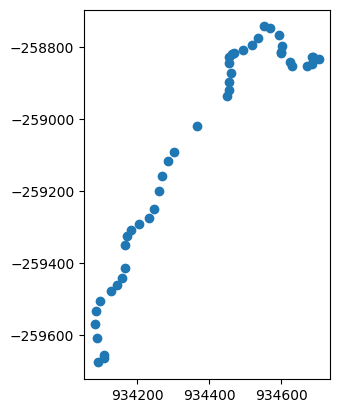

In [377]:
run_id = 'f8b504cf58e9643370192bc078ff603cb80efbc9'

test_ = nodes.copy()
test = [x for x in test_ if [y for y in x.get("features") if y.get("id_connection") == run_id]]

print(LineString(points[points.id==run_id].geometry).length)
points[points.id==run_id].geometry.plot()



start_point = start_end_points[(start_end_points.id == run_id) & (start_end_points.point_type=="start")].geometry.any().coords[0]
subsample = [x for x in test if [y for y in x.get("features") if y.get("id_connection") == run_id]]
subsample_sorted = sorted(subsample, key=lambda x: x.get("coords")[2], reverse=True)

run_points = points[points.id== run_id].geometry
length_run = LineString(run_points).length
run_points, start_point = tow_sided_run(run_points, start_point)
length_segments = []

if len(subsample_sorted) > 1:

    for i in range(1, len(subsample_sorted)):
        run_segment = []

        print(start_point[2])
        for point in run_points:
            if point.coords[0][2] <= start_point[2] and point.coords[0][2] >= subsample_sorted[i].get("coords")[2]:
                run_segment.append(point)
                print(point)
        length_segment = LineString(run_segment).length
        length_run = length_run - length_segment
        start_point = subsample_sorted[i].get("coords")
        length_segments.append(length_segment)
        print(length_segment)
        print(length_run)
        print("****")

    length_segments.append(length_run)

elif len(subsample_sorted) == 1:
    length_segments.append(length_run)


length_run = LineString(run_points).length
counter = 0

for node in subsample_sorted:
    for feature in node.get("features"):
        if feature.get("id_connection") == run_id:
            feature["segment_lenght"] = length_segments[counter]
            feature["segment_proportion"] = length_segments[counter] / length_run
    counter += 1

length_segments

<Axes: >

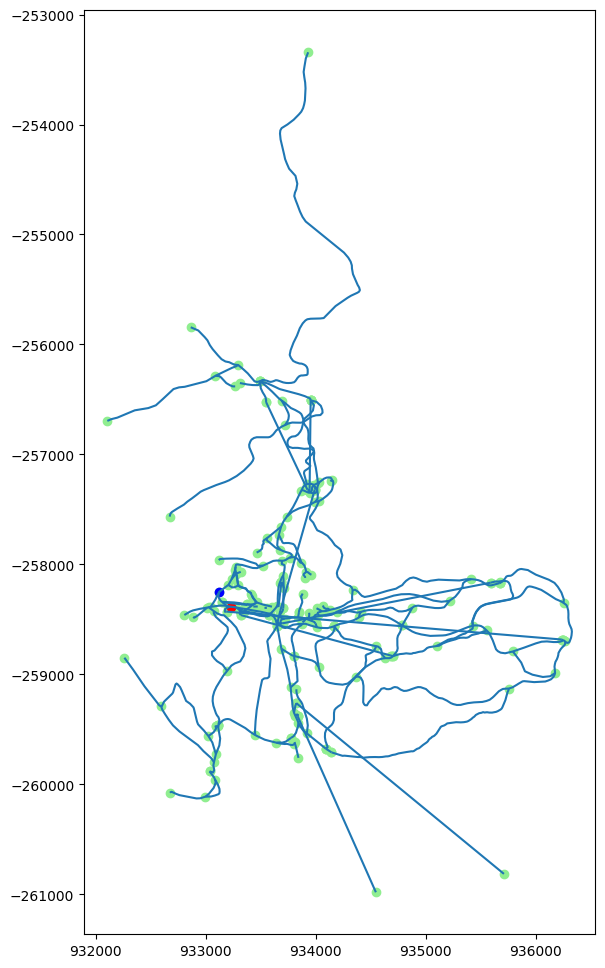

In [481]:
#data = [x for x in nodes if [y for y in x.get("features") if y.get("id_connection") in ['0e97a8ce-a104-4a53-9635-eaf599ab062a', '41aa7c54-1351-439c-989d-6b391d08ad7a', '77c47ed9-fa78-4caf-ab25-3651aff9d4de']]]

data = [x for x in nodes_no_duplicates if x.get("id_node")=='a0bd658a-d93f-4901-b347-37e2ac5b2156']
data_2 = [x for x in nodes_no_duplicates if x.get("id_node") in ['542ee469-28aa-4b02-b8cf-86200a4f0d80'
]]
fig, ax = plt.subplots(figsize=(10,12))
test_data.geometry.plot(ax=ax)
start_end_points.geometry.plot(ax=ax, color="lightgreen")
gpd.GeoDataFrame(data, geometry=[Point(x.get("coords")) for x in data]).plot(ax=ax, color="red")
gpd.GeoDataFrame(data_2, geometry=[Point(x.get("coords")) for x in data_2]).plot(ax=ax, color="blue")

<Axes: >

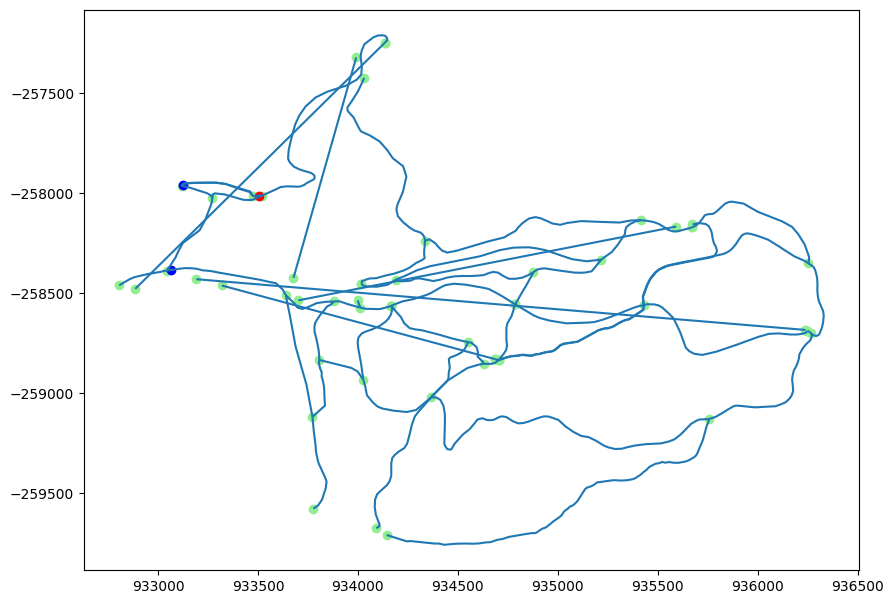

In [310]:
data = [x for x in nodes if x.get("id_node")=="0e97a8ce-a104-4a53-9635-eaf599ab062a"]
data_2 = [x for x in nodes if x.get("id_node") in ['41aa7c54-1351-439c-989d-6b391d08ad7a',
   '77c47ed9-fa78-4caf-ab25-3651aff9d4de',
   '77c47ed9-fa78-4caf-ab25-3651aff9d4de'
]]
fig, ax = plt.subplots(figsize=(10,12))
test_data.geometry.plot(ax=ax)
start_end_points.geometry.plot(ax=ax, color="lightgreen")
gpd.GeoDataFrame(data, geometry=[Point(x.get("coords")) for x in data]).plot(ax=ax, color="red")
gpd.GeoDataFrame(data_2, geometry=[Point(x.get("coords")) for x in data_2]).plot(ax=ax, color="blue")

<Axes: >

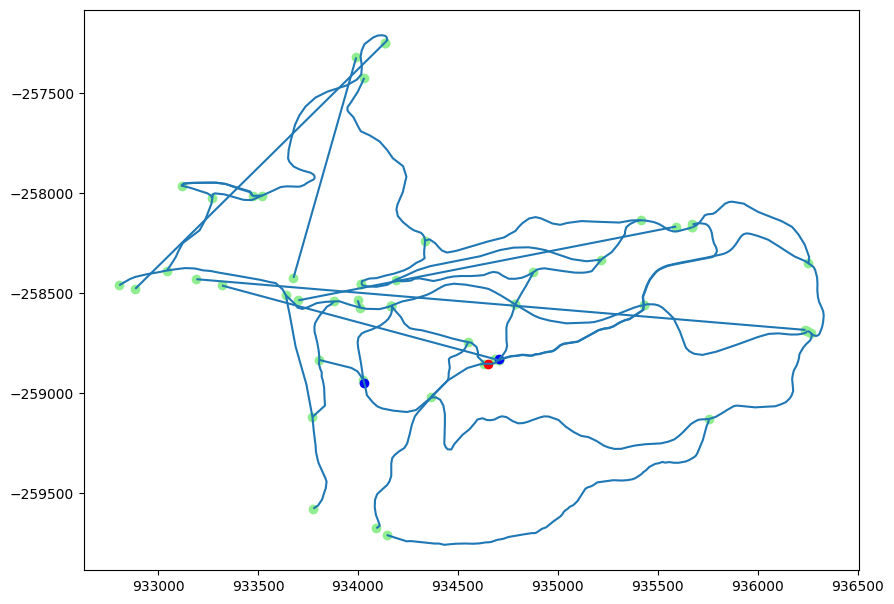

In [315]:
data = [x for x in nodes if x.get("id_node")=='5df5b08c-4585-46b2-a270-01544f88033d']
data_2 = [x for x in nodes if x.get("id_node") in ['c6769e46-f383-4394-be03-dc142b259978',
   'efb19621-52e6-43f2-8e11-a91c48a65830'
]]
fig, ax = plt.subplots(figsize=(10,12))
test_data.geometry.plot(ax=ax)
start_end_points.geometry.plot(ax=ax, color="lightgreen")
gpd.GeoDataFrame(data, geometry=[Point(x.get("coords")) for x in data]).plot(ax=ax, color="red")
gpd.GeoDataFrame(data_2, geometry=[Point(x.get("coords")) for x in data_2]).plot(ax=ax, color="blue")

<Axes: >

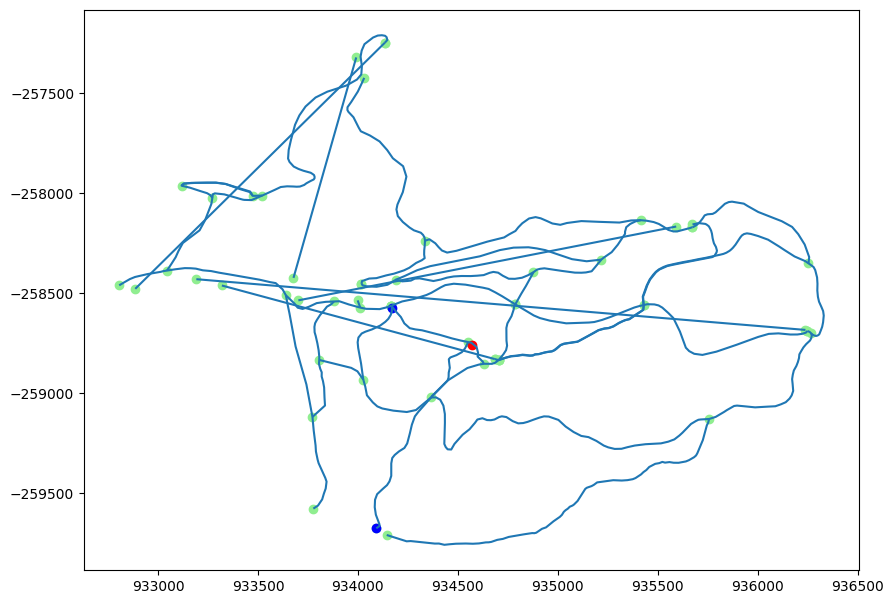

In [317]:
data = [x for x in nodes if x.get("id_node")=='85bc9ef8-5a68-474d-91df-46c5a41860ce']
data_2 = [x for x in nodes if x.get("id_node") in ['62af0ac1-a554-463c-82d9-87a37499f120',
   '8b0b1b6c-aa74-4d43-92a6-8f915de15342'

]]
fig, ax = plt.subplots(figsize=(10,12))
test_data.geometry.plot(ax=ax)
start_end_points.geometry.plot(ax=ax, color="lightgreen")
gpd.GeoDataFrame(data, geometry=[Point(x.get("coords")) for x in data]).plot(ax=ax, color="red")
gpd.GeoDataFrame(data_2, geometry=[Point(x.get("coords")) for x in data_2]).plot(ax=ax, color="blue")

<Axes: >

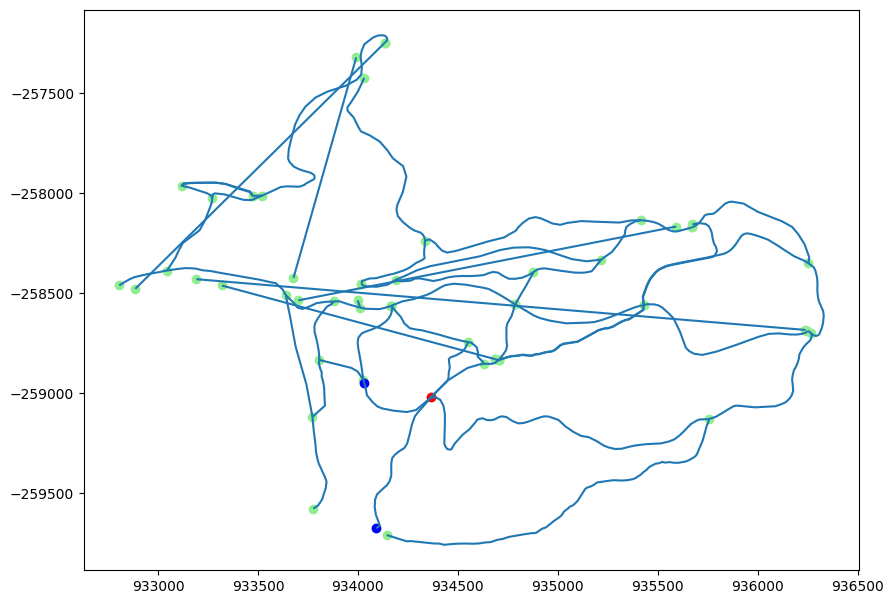

In [318]:
data = [x for x in nodes if x.get("id_node")=='7ce44cf0-de0a-4ce7-8067-e02e60b8cdab']
data_2 = [x for x in nodes if x.get("id_node") in ['8b0b1b6c-aa74-4d43-92a6-8f915de15342',
   'c6769e46-f383-4394-be03-dc142b259978'
]]
fig, ax = plt.subplots(figsize=(10,12))
test_data.geometry.plot(ax=ax)
start_end_points.geometry.plot(ax=ax, color="lightgreen")
gpd.GeoDataFrame(data, geometry=[Point(x.get("coords")) for x in data]).plot(ax=ax, color="red")
gpd.GeoDataFrame(data_2, geometry=[Point(x.get("coords")) for x in data_2]).plot(ax=ax, color="blue")

/var/folders/bz/74yvks6s0yz7n9zj0lsbwc0w0000gn/T/ipykernel_809/1426704743.py:4: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  geo_data[geo_data.id_node.isin(["e47e0245-820e-4fcc-8497-38b9e11ca099"])].plot(ax=ax, color="red")


<Axes: >

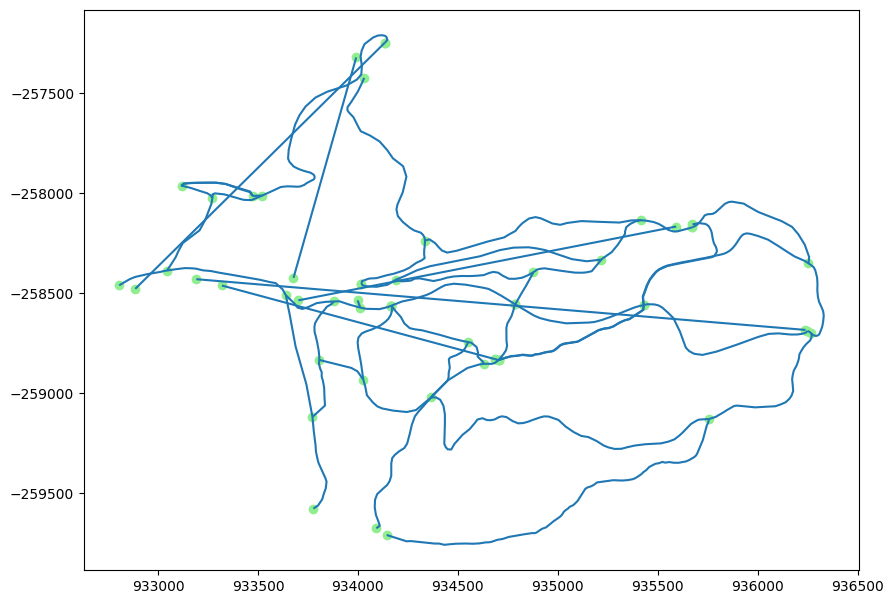

In [216]:
fig, ax = plt.subplots(figsize=(10,12))
test_data.geometry.plot(ax=ax)
start_end_points.geometry.plot(ax=ax, color="lightgreen")
geo_data[geo_data.id_node.isin(["e47e0245-820e-4fcc-8497-38b9e11ca099"])].plot(ax=ax, color="red")

In [104]:
len(nodes)

25

In [61]:
def get_center(nodes):
    x, y, z, n = [0, 0, 0, 0]
    for x_, y_, z_ in [n for n in nodes]:
        x += x_
        y += y_
        z += z_
        n += 1
    return ((x/n), (y/n), (z/n))

In [92]:
nodes_no_duplicates = []
discared_nodes = []
for node in nodes:
    if node.get("id_node") not in discared_nodes:
        duplicate = False
        duplactes_connections = []
        duplactes_coords = []
        for n in nodes:
            if node.get("id_node") != n.get("id_node") and shapely.points(node.get("coords")).distance(shapely.points(n.get("coords"))) < 50:
                duplactes_connections.append(n.get("id_connection")) 
                duplactes_coords.append(n.get("coords"))
                discared_nodes.append(n.get("id_node"))
                duplicate = True

        if duplicate == True:
            nodes_no_duplicates.append({"id_node": node.get("id_node"),
                                        "id_connection": list(np.unique(node.get("id_connection") + sum(duplactes_connections, []))),
                                        "coords": get_center([node.get("coords")] + duplactes_coords)})

        elif duplicate == False:
            nodes_no_duplicates.append({"id_node": node.get("id_node"),
                                        "id_connection": node.get("id_connection"),
                                        "coords": node.get("coords")})

nodes_no_duplicates

[{'id_node': 'aa55dd77-fbfb-4603-8d59-fea36bf03149',
  'id_connection': ['b2cbfe63c2b8626311d669bc02a94b0bee680e1d'],
  'coords': (933712.638106, -258556.3819655, 2292.4849999999997)},
 {'id_node': '63498095-e026-4312-8eb1-8a1e1e959455',
  'id_connection': ['0602c22d0ee93ab4320c45ce4d9d3cea5b49f867',
   '20432332cc7a714c671e4105235d1ce2a757f8cc',
   '327610f1acb523e9c5c26e69b849fb180f9939b7',
   'dd7dbf17741e75c3decec2c7aa2770f792fad61a'],
  'coords': (936250.20568525, -258689.75490174998, 2921.8849999999998)},
 {'id_node': '49c145fc-0334-477a-a1c8-cc7bc703f316',
  'id_connection': ['1744840abdd56aca2391499c8df2c252f1ca31ae',
   '9a242f8d210edc568f6e2df202c03fc1a6ec406d'],
  'coords': (934135.107987, -257245.82739, 2577.0)},
 {'id_node': '0d5284b5-4590-4336-91ad-8d7f27e178bd',
  'id_connection': ['5a8e7b947edaa619fe03e2bce9326a9fa8fdfa33',
   'a1ce835ad3b70417de259f36d9e752aee5a3c45f'],
  'coords': (934894.5608045, -258385.6026265, 2581.685)},
 {'id_node': 'd8d1da03-8abe-435e-812f-f0d9

<Axes: >

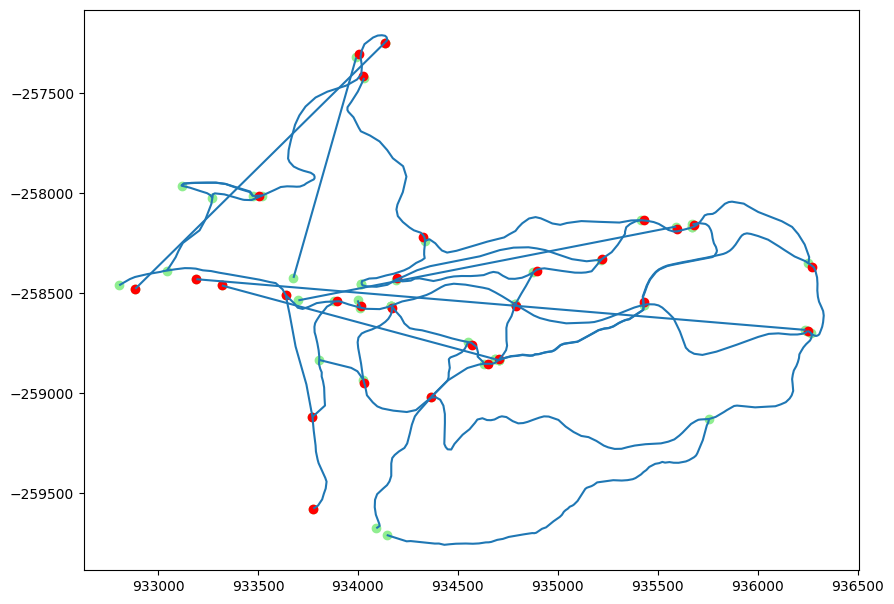

In [217]:
fig, ax = plt.subplots(figsize=(10,12))
test_data.geometry.plot(ax=ax)
start_end_points.geometry.plot(ax=ax, color="lightgreen")
gpd.GeoDataFrame(nodes, geometry=[Point(x.get("coords")) for x in nodes]).plot(ax=ax, color="red")